# Week 11: User-based recommender system (Using cosine_similarity)

In an attempt to familiarize myself with sklearn library, I decided to experiment with another method of user-based recommender system from a tutorial that uses a **user-based collaborative filtering recommendation algorithm**. This algorithm differs from Mr. Bagus' method in several aspects, as the former implements cosine_similairty to measure similarity index as appose to the latter's use of Pearson Correlation. For reference, tutorial can be found at the following link: https://medium.com/grabngoinfo/recommendation-system-user-based-collaborative-filtering-a2e76e3e15c4.


As with my attempt at Mr. Bagus' method, I've used the same hotel rating dataset I found on Kaggle. The dataset can be accesed at the following link: https://www.kaggle.com/datasets/manohar676/hotel-reviews-segmentation-recommended-system?resource=download

In [1]:
# data processing
import pandas as pd
import numpy as np
import scipy.stats
from math import sqrt

# visualization
import seaborn as sns

#similarity (using sklearn)
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
ratings_df = pd.read_csv("user_hotel_rating.csv")

ratings_df.head()

,userid,Hotelid,OverallRating
0,user_78131,hotel_558,3
1,user_78131,hotel_603,2
2,user_78131,hotel_610,3
3,user_78131,hotel_574,3
4,user_78131,hotel_570,3


In [3]:
ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271935 entries, 0 to 271934
Data columns (total 3 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   userid         271935 non-null  object
 1   Hotelid        271935 non-null  object
 2   OverallRating  271935 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 6.2+ MB


In [7]:
# Number of users
print('The ratings dataset has', ratings_df['userid'].nunique(), 'unique users')
# Number of movies
print('The ratings dataset has', ratings_df['Hotelid'].nunique(), 'unique hotels')

The ratings dataset has 5010 unique users
The ratings dataset has 130 unique hotels


In [14]:
# Aggregate by movie
agg_ratings = ratings_df.groupby('Hotelid').agg(mean_rating = ('OverallRating', 'mean'),
                                                number_of_ratings = ('OverallRating', 'count')).reset_index()
# Keep the movies with over 100 ratings
agg_ratings_GT100 = agg_ratings[agg_ratings['number_of_ratings']>120]
agg_ratings_GT100.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 118 entries, 1 to 129
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Hotelid            118 non-null    object 
 1   mean_rating        118 non-null    float64
 2   number_of_ratings  118 non-null    int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 3.7+ KB


In [15]:
# Check popular hotels
agg_ratings_GT100.sort_values(by='number_of_ratings', ascending=False).head()

,Hotelid,mean_rating,number_of_ratings
99,hotel_608,3.490960,2489
110,hotel_620,2.863691,2487
50,hotel_557,3.098110,2487
49,hotel_555,3.076799,2487
47,hotel_552,2.675111,2487


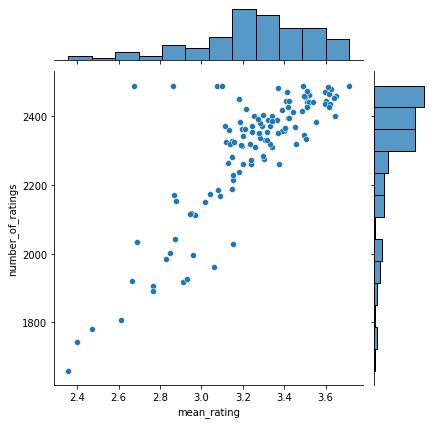

In [16]:
# Visulization
sns.jointplot(x='mean_rating', y='number_of_ratings', data=agg_ratings_GT100)

In [17]:
# Merge data
df_GT100 = pd.merge(ratings_df, agg_ratings_GT100[['Hotelid']], on='Hotelid', how='inner')
df_GT100.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 271257 entries, 0 to 271256
Data columns (total 3 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   userid         271257 non-null  object
 1   Hotelid        271257 non-null  object
 2   OverallRating  271257 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 8.3+ MB


In [19]:
# Number of users
print('The ratings dataset has', df_GT100['userid'].nunique(), 'unique users')
# Number of hotels
print('The ratings dataset has', df_GT100['Hotelid'].nunique(), 'unique hotels')

The ratings dataset has 5010 unique users
The ratings dataset has 118 unique hotels


In [20]:
# Create user-item matrix
matrix = df_GT100.pivot_table(index='userid', columns='Hotelid', values='OverallRating')
matrix.head()

Hotelid,hotel_502,hotel_503,hotel_504,hotel_506,hotel_507,hotel_508,hotel_509,hotel_510,hotel_511,hotel_512,...,hotel_630,hotel_631,hotel_632,hotel_633,hotel_634,hotel_635,hotel_636,hotel_637,hotel_639,hotel_640
userid,,,,,,,,,,,,,,,,,,,,,
user_21002,3.0,NaN,3.0,3.0,NaN,4.0,NaN,3.0,NaN,NaN,...,4.0,NaN,NaN,3.0,NaN,NaN,NaN,3.0,NaN,NaN
user_21025,NaN,NaN,2.0,NaN,NaN,NaN,3.0,3.0,2.0,NaN,...,NaN,2.0,NaN,NaN,4.0,2.0,NaN,NaN,3.0,3.0
user_21042,NaN,NaN,NaN,4.0,NaN,3.0,NaN,3.0,NaN,3.0,...,NaN,NaN,2.0,NaN,NaN,NaN,2.0,NaN,2.0,NaN
user_21051,2.0,5.0,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,...,5.0,5.0,NaN,NaN,5.0,5.0,5.0,5.0,NaN,5.0
user_21054,1.0,NaN,1.0,NaN,3.0,4.0,2.0,NaN,4.0,NaN,...,4.0,NaN,NaN,NaN,3.0,2.0,1.0,2.0,4.0,4.0


In [21]:
# Normalize user-item matrix
matrix_norm = matrix.subtract(matrix.mean(axis=1), axis = 'rows')
matrix_norm.head()

Hotelid,hotel_502,hotel_503,hotel_504,hotel_506,hotel_507,hotel_508,hotel_509,hotel_510,hotel_511,hotel_512,...,hotel_630,hotel_631,hotel_632,hotel_633,hotel_634,hotel_635,hotel_636,hotel_637,hotel_639,hotel_640
userid,,,,,,,,,,,,,,,,,,,,,
user_21002,-0.275000,NaN,-0.275000,-0.275000,NaN,0.725000,NaN,-0.275000,NaN,NaN,...,0.725000,NaN,NaN,-0.275,NaN,NaN,NaN,-0.275000,NaN,NaN
user_21025,NaN,NaN,-0.982759,NaN,NaN,NaN,0.017241,0.017241,-0.982759,NaN,...,NaN,-0.982759,NaN,NaN,1.017241,-0.982759,NaN,NaN,0.017241,0.017241
user_21042,NaN,NaN,NaN,1.590164,NaN,0.590164,NaN,0.590164,NaN,0.590164,...,NaN,NaN,-0.409836,NaN,NaN,NaN,-0.409836,NaN,-0.409836,NaN
user_21051,-2.943396,0.056604,NaN,0.056604,NaN,NaN,NaN,NaN,NaN,NaN,...,0.056604,0.056604,NaN,NaN,0.056604,0.056604,0.056604,0.056604,NaN,0.056604
user_21054,-1.586207,NaN,-1.586207,NaN,0.413793,1.413793,-0.586207,NaN,1.413793,NaN,...,1.413793,NaN,NaN,NaN,0.413793,-0.586207,-1.586207,-0.586207,1.413793,1.413793


In [22]:
# User similarity matrix using Pearson correlation
user_similarity = matrix_norm.T.corr()
user_similarity.head()

userid,user_21002,user_21025,user_21042,user_21051,user_21054,user_21058,user_21062,user_21073,user_21101,user_21114,...,user_79950,user_79957,user_79970,user_80019,user_80020,user_80060,user_80071,user_80089,user_80090,user_80123
userid,,,,,,,,,,,,,,,,,,,,,
user_21002,1.000000,0.295439,0.305897,0.233550,0.535700,0.568399,0.146711,0.385833,0.053093,0.241624,...,0.238416,0.415169,0.146409,0.028215,-0.120598,0.476731,-0.176547,0.063969,0.091003,0.315716
user_21025,0.295439,1.000000,0.314334,NaN,0.437189,0.127973,-0.216206,0.215387,0.101272,0.141204,...,-0.062409,0.562984,0.182967,0.166196,-0.621893,0.258494,0.240627,-0.005562,-0.489086,-0.193476
user_21042,0.305897,0.314334,1.000000,NaN,0.182041,0.123009,-0.113722,0.153328,-0.146561,0.076841,...,-0.102074,0.336292,-0.093962,-0.273584,-0.128112,-0.220968,0.072791,0.089121,-0.455083,-0.169941
user_21051,0.233550,NaN,NaN,1.000000,0.258627,NaN,NaN,0.121716,0.179724,NaN,...,0.188275,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.073398,0.031814
user_21054,0.535700,0.437189,0.182041,0.258627,1.000000,0.126426,0.143172,0.090273,0.038607,-0.042279,...,-0.181605,0.220853,0.292197,0.190914,-0.180168,0.093761,-0.246576,-0.010298,-0.171009,-0.059655


In [23]:
# User similarity matrix using cosine similarity
user_similarity_cosine = cosine_similarity(matrix_norm.fillna(0))
user_similarity_cosine

array([[ 1.        ,  0.10485953,  0.13514382, ...,  0.02692199,
         0.03372955,  0.16660656],
       [ 0.10485953,  1.        ,  0.10182024, ..., -0.00475575,
        -0.25514713, -0.07668623],
       [ 0.13514382,  0.10182024,  1.        , ...,  0.08912116,
        -0.21471211, -0.05411725],
       ...,
       [ 0.02692199, -0.00475575,  0.08912116, ...,  1.        ,
        -0.02095841,  0.01212657],
       [ 0.03372955, -0.25514713, -0.21471211, ..., -0.02095841,
         1.        ,  0.04428279],
       [ 0.16660656, -0.07668623, -0.05411725, ...,  0.01212657,
         0.04428279,  1.        ]])

In [33]:
# Pick a user ID
picked_userid = 'user_36719'
# Remove picked user ID from the candidate list
user_similarity.drop(index=picked_userid, inplace=True)
# Take a look at the data
user_similarity.head()

userid,user_21002,user_21025,user_21042,user_21051,user_21054,user_21058,user_21062,user_21073,user_21101,user_21114,...,user_79950,user_79957,user_79970,user_80019,user_80020,user_80060,user_80071,user_80089,user_80090,user_80123
userid,,,,,,,,,,,,,,,,,,,,,
user_21002,1.000000,0.295439,0.305897,0.233550,0.535700,0.568399,0.146711,0.385833,0.053093,0.241624,...,0.238416,0.415169,0.146409,0.028215,-0.120598,0.476731,-0.176547,0.063969,0.091003,0.315716
user_21025,0.295439,1.000000,0.314334,NaN,0.437189,0.127973,-0.216206,0.215387,0.101272,0.141204,...,-0.062409,0.562984,0.182967,0.166196,-0.621893,0.258494,0.240627,-0.005562,-0.489086,-0.193476
user_21042,0.305897,0.314334,1.000000,NaN,0.182041,0.123009,-0.113722,0.153328,-0.146561,0.076841,...,-0.102074,0.336292,-0.093962,-0.273584,-0.128112,-0.220968,0.072791,0.089121,-0.455083,-0.169941
user_21051,0.233550,NaN,NaN,1.000000,0.258627,NaN,NaN,0.121716,0.179724,NaN,...,0.188275,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.073398,0.031814
user_21054,0.535700,0.437189,0.182041,0.258627,1.000000,0.126426,0.143172,0.090273,0.038607,-0.042279,...,-0.181605,0.220853,0.292197,0.190914,-0.180168,0.093761,-0.246576,-0.010298,-0.171009,-0.059655


In [42]:
# Number of similar users
n = 10
# User similarity threashold
user_similarity_threshold = 0.6
# Get top n similar users
similar_users = user_similarity[user_similarity[picked_userid]>user_similarity_threshold][picked_userid].sort_values(ascending=False)[:n]
# Print out top n similar users
print(f'The similar users for user {picked_userid} are', similar_users)

The similar users for user user_36719 are userid
user_21054    1.0
user_51361    1.0
user_50964    1.0
user_50879    1.0
user_50554    1.0
user_50553    1.0
user_50206    1.0
user_49967    1.0
user_49938    1.0
user_49848    1.0
Name: user_36719, dtype: float64


In [43]:
# Hotels that the target user has stayed in
picked_userid_stay = matrix_norm[matrix_norm.index == picked_userid].dropna(axis=1, how='all')
picked_userid_stay

Hotelid,hotel_547,hotel_552,hotel_555,hotel_557,hotel_559,hotel_620,hotel_622,hotel_628,hotel_630
userid,,,,,,,,,
user_36719,-0.777778,-1.777778,0.222222,-0.777778,0.222222,0.222222,-0.777778,2.222222,1.222222


In [44]:
# Hotels that similar users stayed in. Remove hotels that none of the similar users have stayed in
similar_user_hotels = matrix_norm[matrix_norm.index.isin(similar_users.index)].dropna(axis=1, how='all')
similar_user_hotels

Hotelid,hotel_502,hotel_503,hotel_504,hotel_506,hotel_507,hotel_508,hotel_509,hotel_510,hotel_511,hotel_512,...,hotel_630,hotel_631,hotel_632,hotel_633,hotel_634,hotel_635,hotel_636,hotel_637,hotel_639,hotel_640
userid,,,,,,,,,,,,,,,,,,,,,
user_21054,-1.586207,NaN,-1.586207,NaN,0.413793,1.413793,-0.586207,NaN,1.413793,NaN,...,1.413793,NaN,NaN,NaN,0.413793,-0.586207,-1.586207,-0.586207,1.413793,1.413793
user_49848,-1.000000,-1.000000,0.000000,1.000000,NaN,NaN,0.000000,NaN,-1.000000,NaN,...,NaN,NaN,NaN,0.000000,NaN,0.000000,NaN,1.000000,0.000000,NaN
user_49938,0.966102,NaN,NaN,NaN,NaN,-0.033898,-0.033898,-0.033898,-0.033898,NaN,...,NaN,-0.033898,-0.033898,-0.033898,NaN,NaN,-0.033898,-1.033898,NaN,NaN
user_49967,NaN,-0.736842,NaN,0.263158,NaN,NaN,0.263158,0.263158,1.263158,NaN,...,NaN,1.263158,0.263158,NaN,0.263158,NaN,-0.736842,0.263158,1.263158,NaN
user_50206,NaN,NaN,NaN,NaN,0.688889,NaN,0.688889,NaN,-1.311111,1.688889,...,NaN,NaN,NaN,-1.311111,-0.311111,NaN,NaN,NaN,NaN,1.688889
user_50553,-0.232143,-1.232143,NaN,NaN,NaN,-0.232143,NaN,-0.232143,1.767857,-1.232143,...,1.767857,0.767857,NaN,1.767857,NaN,0.767857,NaN,0.767857,-0.232143,NaN
user_50554,NaN,NaN,-1.619048,0.380952,1.380952,NaN,1.380952,0.380952,NaN,-0.619048,...,1.380952,NaN,NaN,NaN,NaN,-1.619048,NaN,NaN,-0.619048,NaN
user_50879,NaN,0.111111,NaN,NaN,NaN,NaN,NaN,NaN,0.111111,NaN,...,0.111111,NaN,1.111111,NaN,NaN,0.111111,0.111111,NaN,NaN,1.111111
user_50964,NaN,-1.178571,NaN,-0.178571,NaN,0.821429,NaN,NaN,-0.178571,-1.178571,...,0.821429,NaN,-0.178571,-2.178571,NaN,NaN,NaN,-0.178571,NaN,NaN


In [46]:
# Remove the hotels from the hotel list
similar_user_hotels.drop(picked_userid_stay.columns,axis=1, inplace=True, errors='ignore')
similar_user_hotels

Hotelid,hotel_502,hotel_503,hotel_504,hotel_506,hotel_507,hotel_508,hotel_509,hotel_510,hotel_511,hotel_512,...,hotel_629,hotel_631,hotel_632,hotel_633,hotel_634,hotel_635,hotel_636,hotel_637,hotel_639,hotel_640
userid,,,,,,,,,,,,,,,,,,,,,
user_21054,-1.586207,NaN,-1.586207,NaN,0.413793,1.413793,-0.586207,NaN,1.413793,NaN,...,NaN,NaN,NaN,NaN,0.413793,-0.586207,-1.586207,-0.586207,1.413793,1.413793
user_49848,-1.000000,-1.000000,0.000000,1.000000,NaN,NaN,0.000000,NaN,-1.000000,NaN,...,NaN,NaN,NaN,0.000000,NaN,0.000000,NaN,1.000000,0.000000,NaN
user_49938,0.966102,NaN,NaN,NaN,NaN,-0.033898,-0.033898,-0.033898,-0.033898,NaN,...,-0.033898,-0.033898,-0.033898,-0.033898,NaN,NaN,-0.033898,-1.033898,NaN,NaN
user_49967,NaN,-0.736842,NaN,0.263158,NaN,NaN,0.263158,0.263158,1.263158,NaN,...,1.263158,1.263158,0.263158,NaN,0.263158,NaN,-0.736842,0.263158,1.263158,NaN
user_50206,NaN,NaN,NaN,NaN,0.688889,NaN,0.688889,NaN,-1.311111,1.688889,...,-1.311111,NaN,NaN,-1.311111,-0.311111,NaN,NaN,NaN,NaN,1.688889
user_50553,-0.232143,-1.232143,NaN,NaN,NaN,-0.232143,NaN,-0.232143,1.767857,-1.232143,...,NaN,0.767857,NaN,1.767857,NaN,0.767857,NaN,0.767857,-0.232143,NaN
user_50554,NaN,NaN,-1.619048,0.380952,1.380952,NaN,1.380952,0.380952,NaN,-0.619048,...,NaN,NaN,NaN,NaN,NaN,-1.619048,NaN,NaN,-0.619048,NaN
user_50879,NaN,0.111111,NaN,NaN,NaN,NaN,NaN,NaN,0.111111,NaN,...,0.111111,NaN,1.111111,NaN,NaN,0.111111,0.111111,NaN,NaN,1.111111
user_50964,NaN,-1.178571,NaN,-0.178571,NaN,0.821429,NaN,NaN,-0.178571,-1.178571,...,-0.178571,NaN,-0.178571,-2.178571,NaN,NaN,NaN,-0.178571,NaN,NaN


In [47]:
# A dictionary to store item scores
item_score = {}
# Loop through items
for i in similar_user_hotels.columns:
  # Get the ratings for movie i
  movie_rating = similar_user_hotels[i]
  # Create a variable to store the score
  total = 0
  # Create a variable to store the number of scores
  count = 0
  # Loop through similar users
  for u in similar_users.index:
    # If the movie has rating
    if pd.isna(movie_rating[u]) == False:
      # Score is the sum of user similarity score multiply by the movie rating
      score = similar_users[u] * movie_rating[u]
      # Add the score to the total score for the movie so far
      total += score
      # Add 1 to the count
      count +=1
  # Get the average score for the item
  item_score[i] = total / count
# Convert dictionary to pandas dataframe
item_score = pd.DataFrame(item_score.items(), columns=['hotel', 'hotel_ratings'])
    
# Sort the movies by score
ranked_item_score = item_score.sort_values(by='hotel_ratings', ascending=False)
# Select top m movies
m = 2
ranked_item_score

,hotel,hotel_ratings
77,hotel_601,1.745074
108,hotel_640,1.293644
69,hotel_587,1.162646
67,hotel_585,1.121947
21,hotel_527,0.957309
...,...,...
45,hotel_560,-1.040283
89,hotel_615,-1.057875
2,hotel_504,-1.068418
74,hotel_597,-1.116071
